In [1]:
# Import relevant libraries
import yahoo_fin.options as ops
import yahoo_fin.stock_info as si
import opstrat as op
import datetime
import pandas as pd
from optionprice import Option
from dateutil import parser

In [2]:
# Get today's date
today = datetime.date.today()
todaysDate = today.strftime('%m/%d/%Y')

In [3]:
# User enters stock for options trading
stock = input("Enter Stock\n>>>")

Enter Stock
>>>SOFI


In [4]:
# Get expiry dates of stock options from input
expirationDates = ops.get_expiration_dates(stock)
expirationDatesdf = pd.DataFrame(expirationDates, columns=['Expiration Dates'])
expirationDatesdf

,Expiration Dates
0,"May 12, 2023"
1,"May 19, 2023"
2,"May 26, 2023"
3,"June 2, 2023"
4,"June 9, 2023"
5,"June 16, 2023"
6,"June 23, 2023"
7,"July 21, 2023"
8,"October 20, 2023"
9,"December 15, 2023"


In [5]:
# User enter's option date of choice
optionDate = input('Enter a date from above that you\'d like to exercise an options trade(s)\n>>>')

Enter a date from above that you'd like to exercise an options trade(s)
>>>December 15, 2023


In [6]:
# Format expiry date to mm/dd/yyyy
dateObj = parser.parse(optionDate)
formattedExpiryDate = dateObj.strftime("%m/%d/%Y")

In [7]:
# Get call options of stock for provided expiry date
calls = ops.get_calls(stock,optionDate)
calls.set_index("Contract Name",inplace = True)

In [8]:
# Get put options of stock for provided expiry date
puts = ops.get_puts(stock,optionDate)
puts.set_index("Contract Name",inplace = True)

In [9]:
# Enter price of stock at option expiry (strike price)
strike = float(input('Enter a strike price in USD for your option(s)\n E.G.: 2.5\n>>>'))

Enter a strike price in USD for your option(s)
 E.G.: 2.5
>>>2.5


### Data Allocation

In [10]:
# Get data from stock's most recent close
daily = si.get_data(stock, start_date="04/26/2022", end_date=todaysDate, index_as_date = True, interval="1d")
today = daily.iloc[-1]

In [11]:
# Get stock's most recent price to use as Spot Price
spot = today[3]

In [12]:
#Difference in days between Expiry Date and Today's Date

date_format = "%m/%d/%Y"
date1 = datetime.datetime.strptime(todaysDate, date_format)
date2 = datetime.datetime.strptime(formattedExpiryDate, date_format)



# Calculate the difference
timedelta = date2 - date1

# Convert the difference to a number of days
days = timedelta.days

### Get Treasury rate for determining option price

In [13]:
url = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2023"

In [14]:
dfs = pd.read_html(url)

In [15]:
df = dfs[0]

In [16]:
# Treasury Rate is given by a range of 1 Month to 10 Years.
# This cell maps this range into days from months and years.  Rates are now represented by a number of days,
# and the code below fits the closest bucket of days to the number of days until expiry to determine the most
# appropriate rate to determine the option price

############## Start of Data Wrangling ####################
exclude_start = 1
exclude_end = 9

selected_columns = df.iloc[:, [*range(exclude_start), *range(exclude_end + 1, df.shape[1])]]

selected_columns.set_index('Date',inplace = True)
treasuryRateChart = selected_columns.tail(1).transpose()

newIndex = [30,60,90,120,180,365,365*2,365*3,365*5,365*7,365*10,365*20,365*30]

treasuryRateChart.index = newIndex

newColumnName = ['Rates']
treasuryRateChart.columns = newColumnName
treasuryRateChart.index.name = 'Days'

############### End of Data Wrangling ##################

# Finds the best fit rate based on the number of days until expiry 
closestIndex = min(treasuryRateChart.index, key=lambda x: abs(x - days))
closestValue = treasuryRateChart.loc[closestIndex,'Rates']

### Call Option

In [17]:
# Get data from call option based on expiry date and strike price
call = calls[calls['Strike'] == strike]
call = call.to_dict(orient='records')[0]

In [18]:
#Get implied volatility from option
percentage_float = float(call['Implied Volatility'].strip('%'))/100

In [19]:
#Define option
option_det = Option(european=True,
                    kind='call',
                    s0=spot,
                    k=strike,
                    t=days,
                    sigma=percentage_float,
                    r= (closestValue/100),
                    dv=0)

In [20]:
# Get option price
priceCall = option_det.getPrice(method='BSM',iteration=5000)

In [21]:
# Create dataframe that shows payoffs of option based on probable Equity Prices at Expiry
#pct_change = int(Strike/10)
ploss = {'Equity Market Price at Expiry': [spot*.7,spot*.8,spot*.9,
                                           spot,spot*1.1,spot*1.2,spot*1.3]}
## Ask for number of contracts
sperc = 100*1 #100 shares per contract
df = pd.DataFrame(ploss, columns = ['Equity Market Price at Expiry','Profit/Loss Call'])
payoffs = []
for i in df['Equity Market Price at Expiry']:

# Calculate Option Payoffs
        payoff = max(((i - strike) * sperc) - (priceCall*sperc),-priceCall*sperc)
        payoffs.append(payoff)

# Create DataFrame
ploss['Profit/Loss Call']=payoffs
final1=pd.DataFrame(ploss,columns=['Equity Market Price at Expiry','Profit/Loss Call']).set_index('Equity Market Price at Expiry')

final1

,Profit/Loss Call
Equity Market Price at Expiry,
3.612,-182.059642
4.128,-130.459643
4.644,-78.859645
5.160,-27.259646
5.676,24.340352
6.192,75.940351
6.708,127.540349


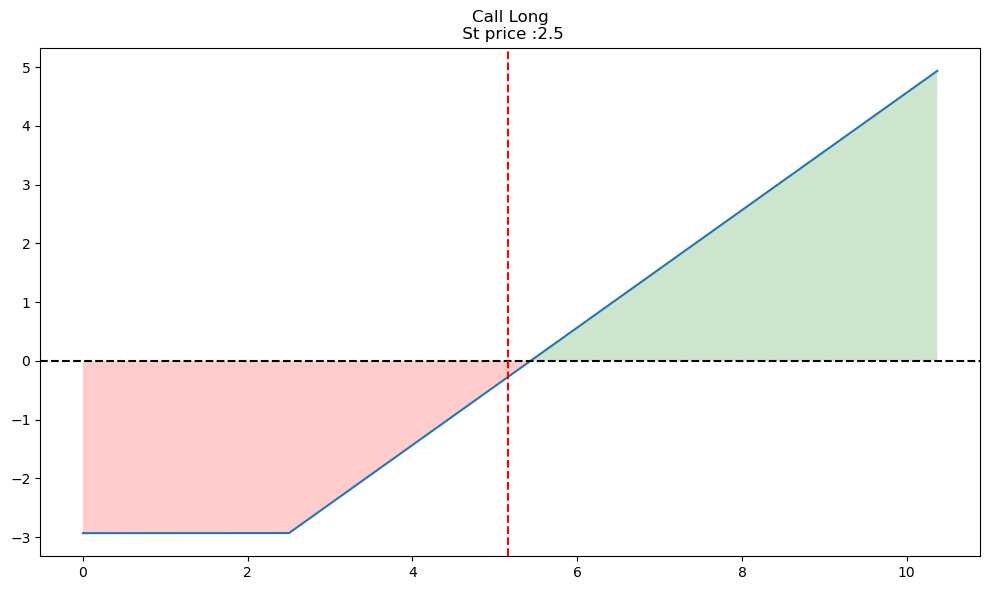

In [22]:
# Plot Option
op.single_plotter(spot=spot, strike=strike, op_type='c', tr_type='b', op_pr=priceCall,spot_range = 100)

### Put Option

In [23]:
# Get data from put option based on expiry date and strike price
put = puts[puts['Strike'] == strike]
put = put.to_dict(orient='records')[0]

In [24]:
#Get implied volatility from option
percentage_float = float(put['Implied Volatility'].strip('%'))/100

In [25]:
# Define option and get option price 
option_det = Option(european=True,
                    kind='put',
                    s0=spot,
                    k=strike,
                    t=days,
                    sigma=percentage_float,
                    r=closestValue/100,
                    dv=0)

pricePut = option_det.getPrice(method='BSM',iteration=5000)
pricePut

0.13873860540151606

In [26]:
# Get payouts of Put option based off probable equity prices at expiry
ploss = {'Equity Market Price at Expiry': [spot*.7,spot*.8,spot*.9,
                                           spot,spot*1.1,spot*1.2,spot*1.3]}
sperc = 100*1 #100 shares per contract
df = pd.DataFrame(ploss, columns = ['Equity Market Price at Expiry','Profit/Loss Put'])
payoffs = []
for i in df['Equity Market Price at Expiry']:

# Calculate Option Payoffs
        payoff = max(((strike - i) * sperc) - (pricePut*sperc),-pricePut*sperc)
        payoffs.append(payoff)

# Create DataFrame
ploss['Profit/Loss Put']=payoffs
final2=pd.DataFrame(ploss,columns=['Equity Market Price at Expiry','Profit/Loss Put']).set_index('Equity Market Price at Expiry')

final2

,Profit/Loss Put
Equity Market Price at Expiry,
3.612,-13.873861
4.128,-13.873861
4.644,-13.873861
5.160,-13.873861
5.676,-13.873861
6.192,-13.873861
6.708,-13.873861


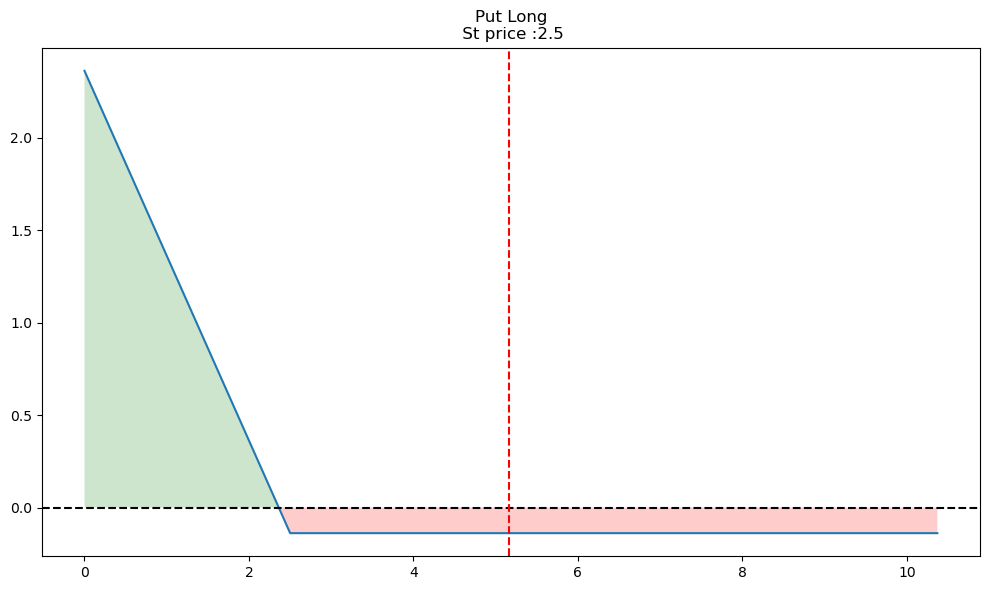

In [27]:
op.single_plotter(spot=spot, strike=strike, op_type='p', tr_type='b', op_pr=pricePut,spot_range = 100)

### Multi Plot

In [28]:
# Join PLs from Call and Put
result = pd.merge(final1, final2, on='Equity Market Price at Expiry', how='inner')
result.fillna(0,inplace = True)
result['P/L'] = result.sum(axis=1)
result[['P/L']].sort_values('Equity Market Price at Expiry')
result.sort_values('Equity Market Price at Expiry')

,Profit/Loss Call,Profit/Loss Put,P/L
Equity Market Price at Expiry,,,
3.612,-182.059642,-13.873861,-195.933502
4.128,-130.459643,-13.873861,-144.333504
4.644,-78.859645,-13.873861,-92.733505
5.160,-27.259646,-13.873861,-41.133507
5.676,24.340352,-13.873861,10.466492
6.192,75.940351,-13.873861,62.066490
6.708,127.540349,-13.873861,113.666489


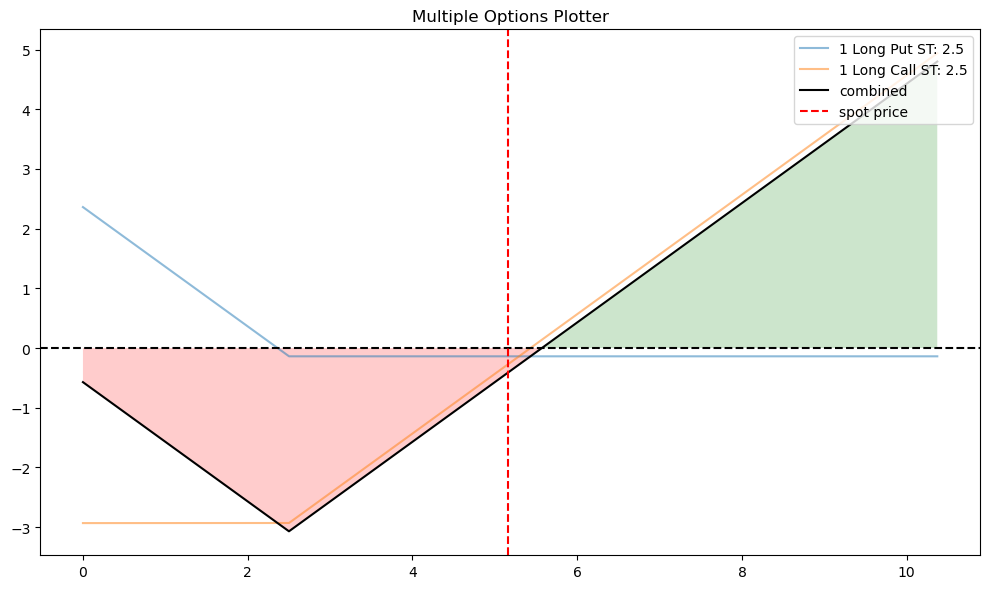

In [29]:
# Plot Put and Call
op1={'op_type': 'p', 'strike': strike, 'tr_type': 'b', 'op_pr': pricePut}
op2={'op_type': 'c', 'strike': strike, 'tr_type': 'b', 'op_pr': priceCall}

op_list=[op1, op2]
op.multi_plotter(spot=spot, op_list=op_list,spot_range = 100)